# Neuro4ML - Week 2 - Synapses and networks

In this week's exercise you'll use different synapse models, excitation and inhibition, and network structure to design a neural network that can determine the temporal order of its inputs.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

## Part 1 - Delays using biexponential synapses

In the cell below we check properties of the biexponential synapse that has equations:

$$\begin{aligned}
\tau \frac{dv}{dt} &= ax-v \\
\tau_x \frac{dx}{dt} &= -x
\end{aligned}$$

If we want to know the effect of an incoming spike that increases $x$ by 1, we can solve with initial conditions

$$\begin{aligned}
v(0) &= 0 \\
x(0) &= 1
\end{aligned}$$

We can see that we can solve for $x$ on its own to just get exponential decay so $x(t)=\exp(-t/\tau_x)$. Then we can just guess (by putting the equations into matrix vector form and noting the matrix is upper triangular and so the eigenvalues are just the diagonal elements) that $v(t)=A\cdot\exp(-t/\tau_x)+B\cdot\exp(-t/\tau)$ and substitute to get the solution:

$$\begin{aligned}
v(t) &= \frac{a\tau_x}{\tau-\tau_x}\left(e^{-t/\tau}-e^{-t/\tau_x}\right) \\
x(t) &= e^{-t/\tau_x}
\end{aligned}$$

Setting $v^\prime(t_0)=0$ and solving for $t_0$ to find the maximum we get

$$t_0 = \frac{\tau\tau_x}{\tau-\tau_x}\log\frac{\tau}{\tau_x}$$

and the maximum value is

$$v(t_0) = a\left(\frac{\tau}{\tau_x}\right)^{-\frac{\tau}{\tau-\tau_x}}$$

Note that we can choose to set $a=(\tau/\tau_x)^{\tau/(\tau-\tau_x)}$ if we want to normalise so that the maximum value $v(t_0)=1$.

### Task 1A

The code below solves this differential equation using Scipy's numerical ODE solver. Write your own code using Euler integration with a time step of ``dt`` and compare to the scipy solution. Compare to the analytic solution derived above.

Reminder: the Euler method for a differential equation $z^\prime=f(z)$ is:

$$z(t+\delta t)\approx z(t)+\delta t \cdot f(z)$$

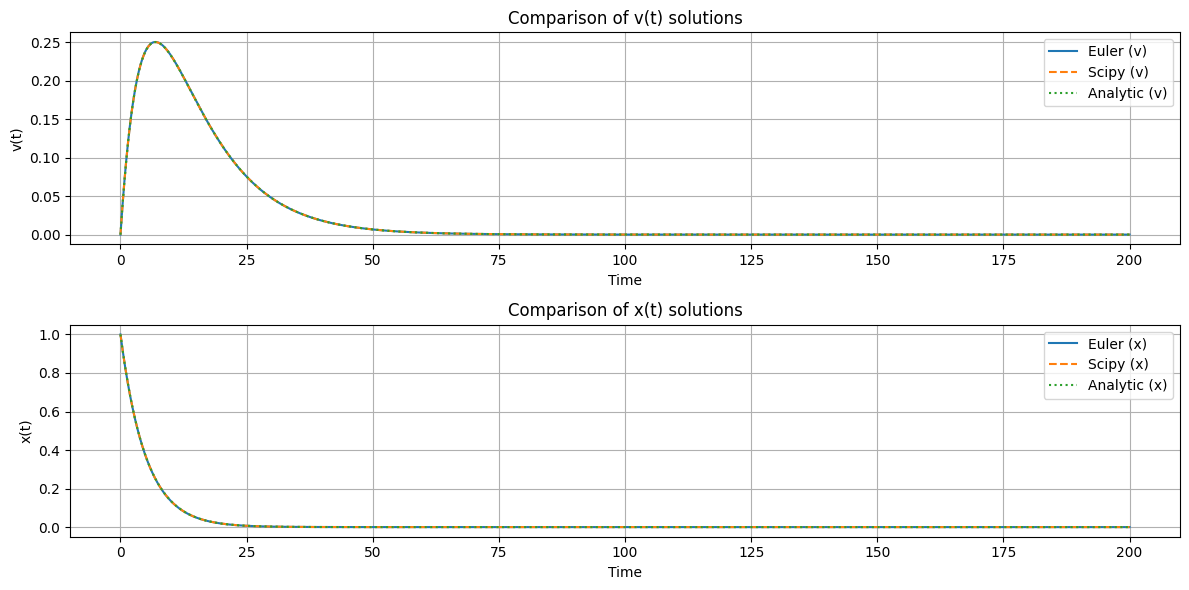

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Parameters
tau_d = 10.0
tau_x =5.0
a_val = 1.0 # We can adjust 'a' for normalization later

# Analytic solution
def analytic_solution(t, tau_d, tau_x, a_val):
    if tau_d == tau_x:
        # Handle the case where tau_d and tau_x are equal (though less common for biexponential)
        # This would require a separate derivation, for now we'll assume they are different.
        # For simplicity in this exercise, we will assume tau_d != tau_x
        return np.zeros_like(t), np.exp(-t / tau_x)

    v_t = a_val * (tau_x / (tau_d - tau_x)) * (np.exp(-t / tau_d) - np.exp(-t / tau_x))
    x_t = np.exp(-t / tau_x)
    return v_t, x_t

# Time array
t_max = 200.0
dt = 0.01
t = np.arange(0, t_max, dt)

# Euler integration
v_euler = np.zeros_like(t)
x_euler = np.zeros_like(t)

# Initial conditions
v_euler[0] = 0.0
x_euler[0] = 1.0

for i in range(len(t) - 1):
    dvdt = (a_val * x_euler[i] - v_euler[i]) / tau_d
    dxdt = -x_euler[i] / tau_x

    v_euler[i+1] = v_euler[i] + dt * dvdt
    x_euler[i+1] = x_euler[i] + dt * dxdt


# Define the differential equations for Scipy
def biexponential_synapse_ode(y, t, tau_d, tau_x, a_val):
    v, x = y
    dvdt = (a_val * x - v) / tau_d
    dxdt = -x / tau_x
    return [dvdt, dxdt]

# Initial conditions for Scipy
y0 = [0.0, 1.0]

# Solve using Scipy's odeint
sol_scipy = odeint(biexponential_synapse_ode, y0, t, args=(tau_d, tau_x, a_val))
v_scipy = sol_scipy[:, 0]
x_scipy = sol_scipy[:, 1]
# Get analytic solution values
v_analytic, x_analytic = analytic_solution(t, tau_d, tau_x, a_val)

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(t, v_euler, label='Euler (v)')
plt.plot(t, v_scipy, label='Scipy (v)', linestyle='--')
plt.plot(t, v_analytic, label='Analytic (v)', linestyle=':')
plt.title('Comparison of v(t) solutions')
plt.xlabel('Time')
plt.ylabel('v(t)')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t, x_euler, label='Euler (x)')
plt.plot(t, x_scipy, label='Scipy (x)', linestyle='--')
plt.plot(t, x_analytic, label='Analytic (x)', linestyle=':')
plt.title('Comparison of x(t) solutions')
plt.xlabel('Time')
plt.ylabel('x(t)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

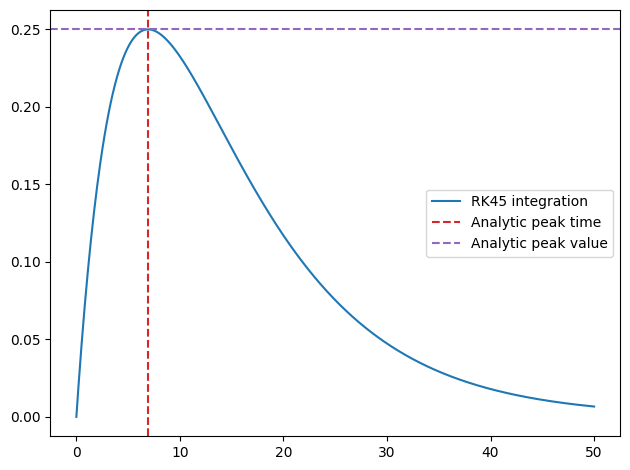

In [3]:
def plot_biexponential_psp(a, tau, taux):
    # differential equation in right form for scipy
    def f(t, z, a, tau, taux):
        v, x = z
        return [(a*x-v)/tau, -x/taux]
    # solution using scipy diffeq solver
    sol = solve_ivp(f, [0, 50], [0, 1], args=(a, tau, taux), max_step=0.1)
    plt.plot(sol.t, sol.y[0], label='RK45 integration')
    # analytic solution
    tmax = tau*taux/(tau-taux)*np.log(tau/taux)
    plt.axvline(tmax, ls='--', c='C3', label='Analytic peak time')
    plt.axhline(((taux/tau)**(tau/(tau-taux))), ls='--', c='C4', label='Analytic peak value')
    plt.legend(loc='best')
    plt.tight_layout()

plot_biexponential_psp(1, 10, 5)



### Task 1B

Show the different range of delays you can get by varying $\tau$ in the range 1-9 ms and $\tau_x$ from 10-100 ms.

### Task 1C

Write a simulator of $N$ neurons using this model, each of which receives a single input spike train at time 0, but with potentially different values of $\tau$ and $\tau_x$ for each neuron. Tune the parameters so that each neuron fires a single output spike with a different delay.

Use the template and test it using the code below to verify that you get similar results.

In [ ]:
def simulate_biexponential_network(num_neurons, tau, taux, duration=10, dt=0.1):
    # state variables
    v = np.zeros(num_neurons)
    x = np.ones(num_neurons)
    # record activity
    num_time_steps = int(duration/dt)
    v_rec = np.zeros((num_neurons, num_time_steps))
    spike_time = np.zeros(num_neurons) # they will only fire one spike each
    # run simulation: FILL IN THE GAP HERE

    return v_rec, spike_time

taux = np.linspace(.5, 9, 10)
tau = 10
v, spike_times = simulate_biexponential_network(len(taux), tau, taux)
T = np.arange(v.shape[1])*0.1
for i in range(len(taux)):
    plt.plot(T, i+v[i, :], '-C0')
    plt.plot(spike_times[i], i+v[i, int(spike_times[i]/0.1)], 'or')
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential for neurons')
plt.yticks([])
plt.tight_layout();

## Part 2 - Order sensitive network with lateral inhibition

In this part, we're going to create a network that takes two spike trains as input, one is delayed relative to the other with some delay, and can determine which spike train is delayed relative to which.

To start with, we'll use this function to generate these spike trains. It takes as an argument the number of time steps to generate, how many spikes there should be overall in each spike train, and a delay (in time steps). It returns an array ``spikes`` of shape ``(2, num_time_steps)`` of 0s and 1s (where 1 indicates a spike at that time). The delay can be positive or negative.

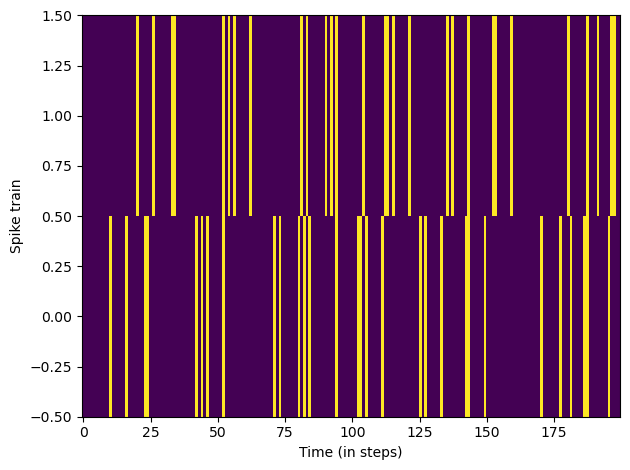

In [ ]:
def create_spike_trains(num_time_steps, num_spikes_per_train, delay):
    max_delay_steps = abs(delay)
    S = np.zeros((2, num_time_steps+2*abs(max_delay_steps)))
    S[0, :num_spikes_per_train] = 1
    np.random.shuffle(S[0, :])
    S[1, max_delay_steps+delay:num_time_steps+delay+max_delay_steps] = S[0, max_delay_steps:num_time_steps+max_delay_steps]
    return S[:, max_delay_steps:num_time_steps+max_delay_steps]

plt.imshow(create_spike_trains(200, 30, 10), origin='lower', interpolation='nearest', aspect='auto')
plt.xlabel('Time (in steps)')
plt.ylabel('Spike train')
plt.tight_layout();

The order sensitive network looks like this:

![Order sensitive network](https://github.com/neuro4ml/exercises/blob/main/w2-synapses-networks/order-sensitive-network.png?raw=1)

Each output neuron receives an excitatory input from the input spike train with the same index, and an inhibitory input from the input spike train with the other index.

This means that if spike train 1 is a delayed version of spike train 0, then neuron 0 will first receive excitatory spikes then inhibitory spikes, allowing it to fire. However, neuron 1 will first receive inhibitory spikes and then excitatory spikes, meaning it won't fire. If on the other hand, spike train 0 is a delayed version of spike train 1, the opposite happens. So which neuron (index 0 or 1) fires a spike tells you the relative order of the input spike trains.

### Task 2

1. Implement this network with instantaneous excitatory and inhibitory synapses (cause an instant increase in $v$). Allow different excitatory and inhibitory weights.
2. Show with two input spike trains each consisting of just one spike that you can reproduce the figure above.
3. Show that using the spike train generator above that it works for sequences of spikes. Use a spike train of length 500 ms with 50 spikes and delays from -10 to +10 ms.

You can use the templates below to get started.

In [ ]:
# vt is the spike threshold (we set it to a large value in the plotting code below to see what's going on)
def simulate_order_network(spikes, tau, we, wi, vt=1, dt=0.1):
    num_neurons = 2
    num_time_steps = spikes.shape[1]
    # state variables
    v = np.zeros(num_neurons)
    x = np.zeros(num_neurons)
    # record activity
    v_rec = np.zeros((num_neurons, num_time_steps))
    spike_count = np.zeros(num_neurons)
    # run simulation: FILL IN THE GAPS HERE
    return v_rec, spike_count

def plotit(order):
    dt = 0.1
    # Input data
    spikes = np.zeros((2, 100))
    spikes[order, 10] = spikes[1-order, 40] = 1
    # Model with threshold set to 10 so we can see traces without spikes
    v, spike_count = simulate_order_network(spikes, tau=10, we=1.2, wi=1, vt=10, dt=dt)
    # Plot
    T = np.arange(v.shape[1])*dt
    for i in range(2):
        plt.subplot(2, 2, 2*i+1+order)
        plt.plot(T, v[i, :])
        plt.axhline(1, ls='--', c='g')
        plt.ylim(-1.5, 1.5)
        if i:
            plt.xlabel('Time (ms)')
        else:
            plt.title(f'Input {order} before input {1-order}')

plt.figure(figsize=(7, 4))
plotit(0)
plotit(1)
plt.tight_layout();

In [ ]:
def order_spike_counts_simulation(d):
    # Input data
    num_time_steps, dt = 5000, 0.1 # 500 ms
    num_spikes = 50
    delay = int(d/dt)
    spikes = create_spike_trains(num_time_steps, num_spikes, delay)
    # Simulation
    v, spike_count = simulate_order_network(spikes, tau=10, we=1.2, wi=1, vt=1, dt=dt)
    return spike_count

D = np.arange(-10, 10+1)
C = [order_spike_counts_simulation(d) for d in D]
plt.plot(D, C, label=('Output 0', 'Output 1'))
plt.legend(loc='best')
plt.xlabel('Relative delay between input spike trains (ms)')
plt.ylabel('Spike count')
plt.tight_layout();


## Part 3 - Tuning the order-sensitive network with slow inhibition

Do the same as in the previous part, but this time make the inhibitory spikes act slowly by adding a biexponential synapse as in part 1. Keep the excitatory spikes instantaneous (they directly increase $v$).

What happens for different inhibitory time constants?

## Part 4 - Cross-correlation network (optional extra)

Can you use the ideas here to build a network with more than two output that can accurately and robustly estimate the time delay between two spike trains? Robust means that it should have properties like:

* It should be invariant to the input spike count.
* It should work if there are additional noise spikes injected.
* It should work if some input spikes are randomly deleted.

What parameters determine performance and robustness?